<a href="https://colab.research.google.com/github/vindeshwariprasad/Thesis/blob/master/Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
from zipfile import ZipFile
import requests

# Define the GitHub repository and folder
repo_url = "https://github.com/vindeshwariprasad/Thesis"
folder_name = "text_dataset"

# Download the repository as a zip file
zip_url = f"{repo_url}/archive/main.zip"
zip_file_path = "/content/main.zip"
response = requests.get(zip_url, stream=True)

# Save the zip file
with open(zip_file_path, 'wb') as file:
    shutil.copyfileobj(response.raw, file)

# Extract the contents of the dataset folder
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Define the dataset path
dataset_folder = f"/content/Thesis-main/{folder_name}"

# Verify if the folder exists
if os.path.exists(dataset_folder):
    print(f"{folder_name} folder exists.")
else:
    print(f"{folder_name} folder not found.")

# Define paths for training and validation folders
nonsensitive_datafile = os.path.join(dataset_folder, "NonSensitiveDataset.json")
sensitive_datafile = os.path.join(dataset_folder, "SensitiveDataset.json")

# Verify if the folders exist
if os.path.exists(nonsensitive_datafile) and os.path.exists(sensitive_datafile):
    print("Training and validation folders exist.")
else:
    print("Training or validation folders not found.")

text_dataset folder exists.
Training and validation folders exist.


In [2]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
    with open(os.path.join(dataset_folder, filename), 'r') as f:
        datastore = json.load(f)
    for item in datastore:
        sentence = item['data']
        label = item['is_sensitive']
        for word in stopwords:  # Remove stop words in sentence
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        dataList.append([sentence, label])

# Loading both sensitive and non-sensitive dataset
loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)

# Shuffling the dataset randomly
random.shuffle(dataList)

# Dataset size: 31500 (approx)
print("Dataset Size: ", len(dataList))

# Dataset has both sentences and labels
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])

# Splitting up the total dataset
# Training size = 20000
# Validation size = 11500 (approx)
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: card no:7332 4917 6389 7327, expiry month:feb-24, card holder name:thangarasu  palani, cvv:253
Validation Dataset Size:  11576
Sample Validation Data: While practicing piano, Alvin sees Louise beaten Spike, rescues brings back Lucretia’s house. Lucretia, owner boarding house Alvin residing, allows Louise stay return chores around house. Eddie meets Spike, black eye incident, former attempts convince Spike let Louise work entertainer him. Spike doesn’t seem enthusiastic shows regret beating her, later credits alcoholism. Spike desire allow daughter escape kind life stuck in, unable change actions without sucked old lifestyle alcohol supplied Eddie.
Eddie learns truth confrontation Alvin Spike dinner Lucretia’s. Later evening, Eddie forcefully attempts bring Louise back “old pappy” Alvin intervenes. Drunk Eddie’s liquor, Spike continues harass Louise contemplates suicide continues. Alvin proposes Louise rescuing alt

In [6]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 102848
Saving the word index as JSON


In [7]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [8]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(24, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            96000     
                                                                 
 conv1d (Conv1D)             (None, 56, 64)            10304     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 107889 (421.44 KB)
Trainable params: 107889 (421.44 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [9]:
num_epochs = 6

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(
                        validation_padded,
                        validation_labels),
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/6
625/625 [==============================] - 8s 11ms/step - loss: 0.0578 - accuracy: 0.9876 - val_loss: 0.0031 - val_accuracy: 0.9998
Epoch 2/6
625/625 [==============================] - 6s 10ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 4.0537e-04 - val_accuracy: 0.9999
Epoch 3/6
625/625 [==============================] - 7s 11ms/step - loss: 6.1898e-04 - accuracy: 0.9999 - val_loss: 1.2712e-04 - val_accuracy: 0.9999
Epoch 4/6
625/625 [==============================] - 6s 9ms/step - loss: 3.5785e-04 - accuracy: 0.9999 - val_loss: 6.7462e-05 - val_accuracy: 1.0000
Epoch 5/6
625/625 [==============================] - 8s 13ms/step - loss: 1.1221e-04 - accuracy: 0.9999 - val_loss: 1.6260e-05 - val_accuracy: 1.0000
Epoch 6/6
625/625 [==============================] - 7s 11ms/step - loss: 6.7220e-05 - accuracy: 0.9999 - val_loss: 1.2144e-05 - val_accuracy: 1.0000


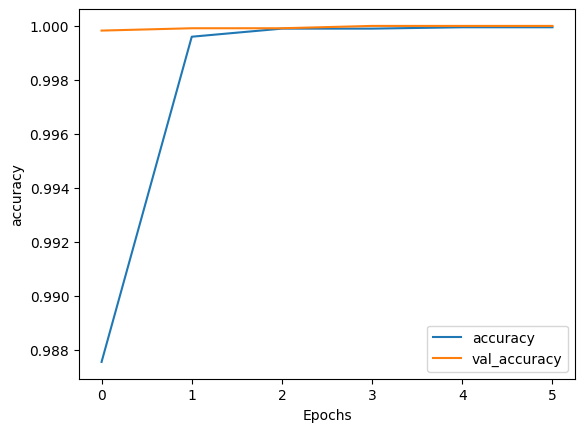

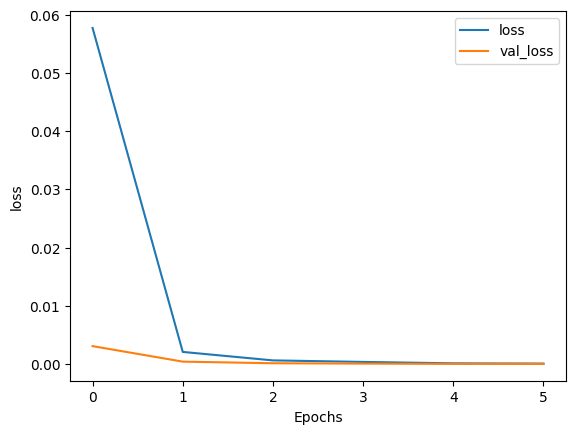

In [10]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Confusion Matrix
362/362 [==============================] - 3s 7ms/step
Accuracy for 2894 Test Data =  100.0
Accuracy for 5788 Test Data =  100.0
Accuracy for 8682 Test Data =  100.0
Accuracy for 11576 Test Data =  100.0


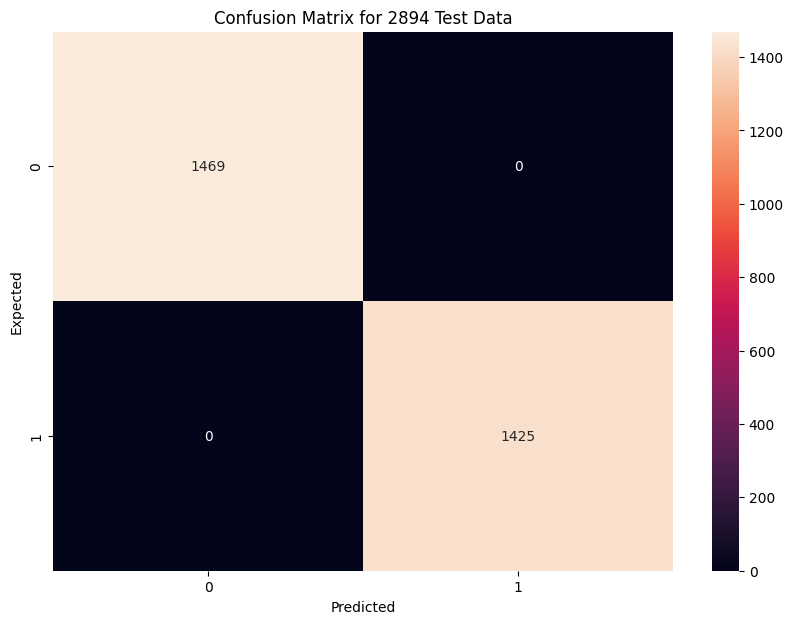

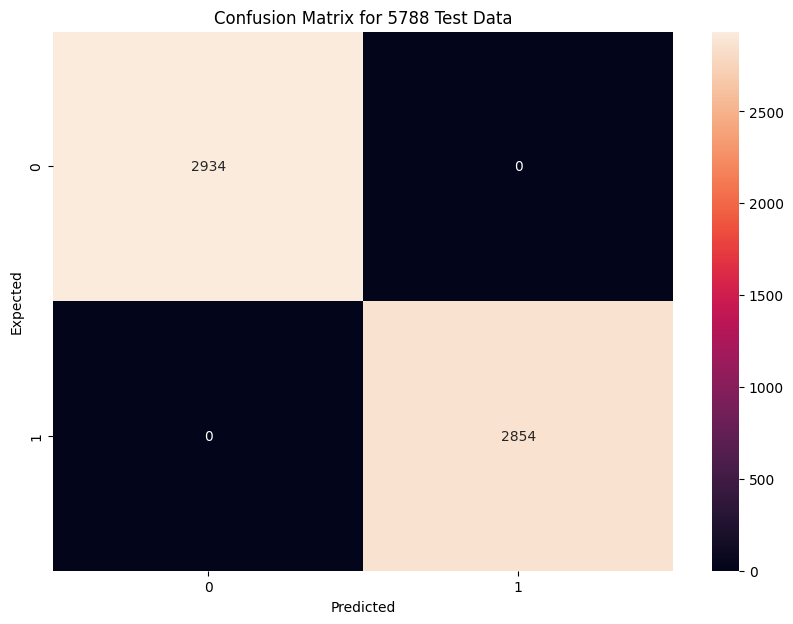

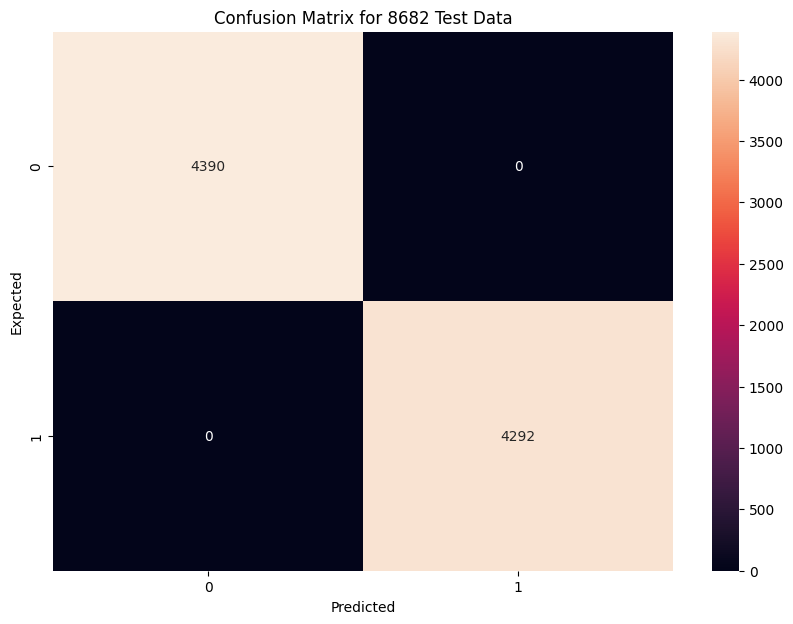

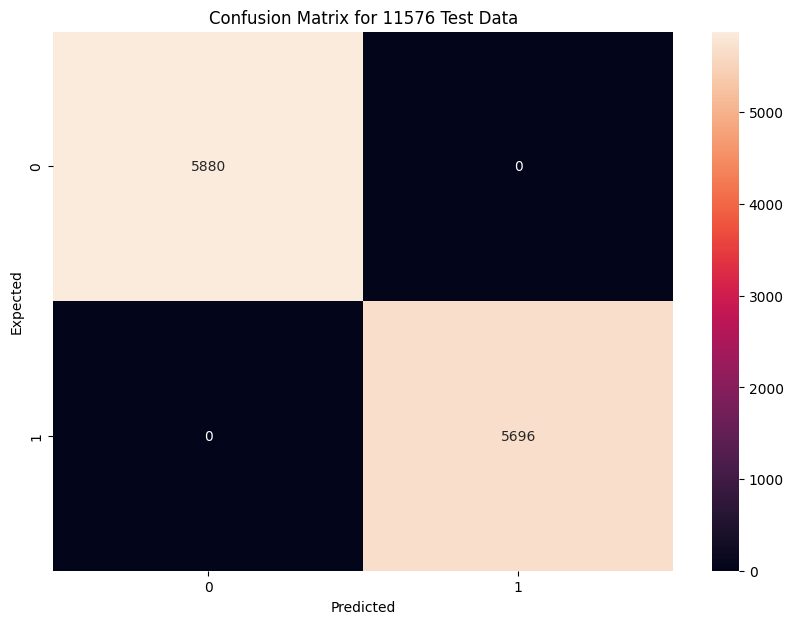

In [11]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

In [12]:
# Save and convert the model (Used for deploying in web application)
model.save('model/text_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/text_model.h5 /content/text_model
print("Model converted to JSON successfully")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved the model successfully
Selecting previously unselected package python3-distlib.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../00-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../01-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-setuptools.
Preparing to unpack .../02-python3-setuptools_59.6.0-1.2ubuntu0.22.04.1_all.deb ...
Unpacking python3-setuptools (59.6.0-1.2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../03-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../04-python3-pip_22.0.2+dfsg-1ubuntu0.4_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.4) ...
Select

In [13]:
import os

model_path = 'model/text_model.h5'
absolute_path = os.path.abspath(model_path)
print("Absolute path of the saved model:", absolute_path)

Absolute path of the saved model: /content/model/text_model.h5


In [14]:
# Sample examples
sentence = ["My Aadhaar no is 146978651", "This sunday we are planning to go to gym."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.5:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

1/1 [==============================] - 0s 41ms/step
0.94630414
Sensitive - My Aadhaar no is 146978651
0.00048436405
Non-Sensitive - This sunday we are planning to go to gym.
